In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import xgboost as xgb  #GBM algorithm
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   # Perforing grid search

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('data/new_train.csv')
test_data = pd.read_csv('data/new_test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1452, 456)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ExterGrade_GdGdGd,ExterGrade_GdGdGdGd,ExterGrade_Po,ExterGrade_PoPo,ExterGrade_TA,ExterGrade_TATA,ExterGrade_TATATA,ExterGrade_TATATATA,Id,SalePrice
0,0.625,0.405761,0.875,0.625,0.998007,0.998007,0.353963,0.440935,0.0,0.096725,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12.247699


(1459, 455)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ExterGrade_GdGd,ExterGrade_GdGdGd,ExterGrade_GdGdGdGd,ExterGrade_Po,ExterGrade_PoPo,ExterGrade_TA,ExterGrade_TATA,ExterGrade_TATATA,ExterGrade_TATATATA,Id
0,0.769231,0.523724,0.625,0.75,0.97708,0.97708,0.0,0.312872,0.286817,0.167887,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1461


In [3]:
import math

def common_num_range(start,stop,step):
    
    startlen = stoplen = steplen = 0
    if '.' in str(start):
        startlen = len(str(start)) - str(start).index('.') - 1
    if '.' in str(stop):
        stoplen = len(str(stop)) - str(stop).index('.') - 1
    if '.' in str(step):
        steplen = len(str(step)) - str(step).index('.') - 1
    
    maxlen = startlen
    if stoplen > maxlen:
        maxlen = stoplen
    if steplen > maxlen:
        maxlen = steplen
    
    power = math.pow(10, maxlen)
    
    if startlen == 0 and stoplen == 0 and steplen == 0:
        return range(start, stop, step)
    else:
        return [num / power for num in range(int(start*power), int(stop*power), int(step*power))]


In [4]:
train_id = train_data['Id']
train_Y = train_data['SalePrice']
train_data.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X = train_data

test_Id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_X = test_data

In [5]:
# formatting for xgb
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

# XGBoost  & Parameter Tuning

Ref: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## Parameters Tuning Plan

The overall parameters can be divided into 3 categories:

1. General Parameters: Guide the overall functioning
2. Booster Parameters: Guide the individual booster (tree/regression) at each step
3. Learning Task Parameters: Guide the optimization performed

In `XGBRegressor`:
```
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
```

In [6]:
# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
def model_cross_validate(xgb_regressor, cv_paramters, dtrain, cv_folds = 5,
              early_stopping_rounds = 50, perform_progress=False):
    """
    xgb model cross validate to choose best param from giving cv_paramters.
    
    @param cv_paramters:dict,where to choose best param. {'param':[1,2,3]}
    @param dtrain:xgboost.DMatrix, training data formatted for xgb
    @param early_stopping_rounds: Activates early stopping.Stop when perfomance 
                                  does not improve for some rounds
    """
    # get initial parameters
    xgb_param = xgb_regressor.get_xgb_params()
    
    # save best param
    best_params = {}
    best_cvresult = None
    min_mean_rmse = float("inf")
    
    for param, values in cv_paramters.items():
        print '===========Tuning paramter:',param,'==========='
        best_param = values[0]
        for value in values:
            # set the param's value
            xgb_param[param] = value
            
            # cv to tune param from values
            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=early_stopping_rounds)

            # calcuate the mean of several final rmses
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
            
            if perform_progress:
                std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()

                if isinstance(value, int):
                    print "%s=%d CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
                else:
                    print "%s=%f CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
            
            if mean_rmse < min_mean_rmse:
                best_param = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse
        
        best_params[param] = best_param
        # set best param value for xgb params, important
        xgb_param[param] = best_param
        print "best ", param, " = ", best_params[param]
    
    return best_params, min_mean_rmse, best_cvresult


In [8]:
def model_fit(xgb_regressor, train_x, train_y, performCV=True, 
              printFeatureImportance=True, cv_folds=5):
    
    # Perform cross-validation
    if performCV:
        xgb_param = xgb_regressor.get_xgb_params()
        cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=50)
        round_count = cvresult.shape[0]
        mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
        std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()
        
        print "CV RMSE : Mean = %.7g | Std = %.7g" % (mean_rmse, std_rmse)
        
    # fir the train data
    xgb_regressor.fit(train_x, train_y)
    
    # Predict training set
    train_predictions = xgb_regressor.predict(train_x)
    mse = rmse(train_y, train_predictions)
    print("Train RMSE: %.7f" % mse)
    
    # Print Feature Importance
    if printFeatureImportance:
        feature_importances = pd.Series(xgb_regressor.feature_importances_, train_x.columns.values)
        feature_importances = feature_importances.sort_values(ascending=False)
        feature_importances= feature_importances.head(40)
        feature_importances.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    return xgb_regressor, feature_importances

Baseline XGBRegressor

CV RMSE : Mean = 0.1219942 | Std = 0.007351074
Train RMSE: 0.0817616


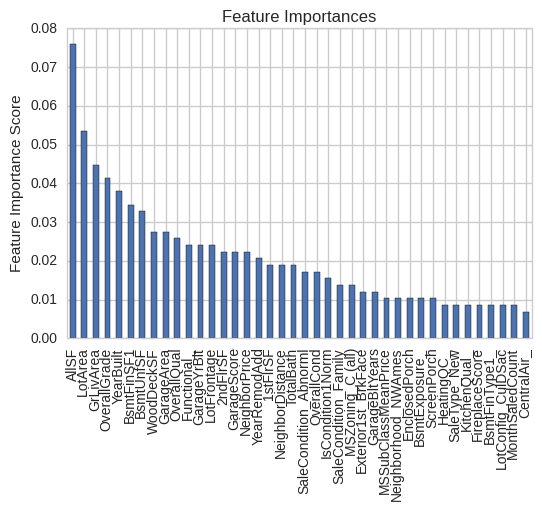

In [9]:
xgb_regressor = XGBRegressor(seed=10)
xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 1. Choose a relatively high learning_rate,optimum n_estimators

In [10]:
param_test = {'n_estimators':range(300,400,10)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,

                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'cross-validate best params:', best_param
print 'cross-validate min_mean_rmse:', min_mean_rmse

===========Tuning paramter: n_estimators ===========
n_estimators=300 CV RMSE : Mean = 0.1198995 | Std = 0.008288507
n_estimators=310 CV RMSE : Mean = 0.1199079 | Std = 0.008310238
n_estimators=320 CV RMSE : Mean = 0.1199223 | Std = 0.008259958
n_estimators=330 CV RMSE : Mean = 0.1199768 | Std = 0.008208978
n_estimators=340 CV RMSE : Mean = 0.1199956 | Std = 0.008165093
n_estimators=350 CV RMSE : Mean = 0.1199492 | Std = 0.008162134
n_estimators=360 CV RMSE : Mean = 0.1199001 | Std = 0.008302044
n_estimators=370 CV RMSE : Mean = 0.1199001 | Std = 0.008302044
n_estimators=380 CV RMSE : Mean = 0.1199001 | Std = 0.008302044
n_estimators=390 CV RMSE : Mean = 0.1199001 | Std = 0.008302044
best  n_estimators  =  300
cross-validate best params: {'n_estimators': 300}
cross-validate min_mean_rmse: 0.119899527273


CV RMSE : Mean = 0.1198995 | Std = 0.008288507
Train RMSE: 0.0380528


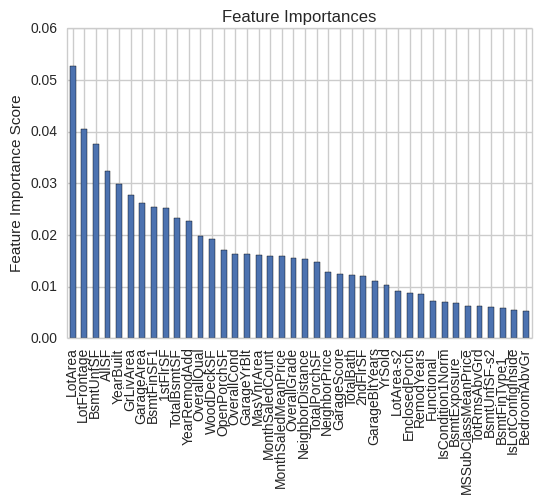

In [11]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,

                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 2.Fix learning rate and number of estimators for tuning tree-based parameters

Tune `max_depth` and `min_child_weight`

In [12]:
param_test = {'max_depth':range(1,6,1),
               'min_child_weight':common_num_range(1,2,0.1)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'cross-validate best params:', best_param
print 'cross-validate min_mean_rmse:', min_mean_rmse

===========Tuning paramter: max_depth ===========
max_depth=1 CV RMSE : Mean = 0.1286357 | Std = 0.009382653
max_depth=2 CV RMSE : Mean = 0.1200461 | Std = 0.0103268
max_depth=3 CV RMSE : Mean = 0.118913 | Std = 0.009591747
max_depth=4 CV RMSE : Mean = 0.119124 | Std = 0.009139826
max_depth=5 CV RMSE : Mean = 0.1198995 | Std = 0.008288507
best  max_depth  =  3
===========Tuning paramter: min_child_weight ===========
min_child_weight=1.000000 CV RMSE : Mean = 0.118913 | Std = 0.009591747
min_child_weight=1.100000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_child_weight=1.200000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_child_weight=1.300000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_child_weight=1.400000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_child_weight=1.500000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_child_weight=1.600000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_child_weight=1.700000 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
min_

CV RMSE : Mean = 0.1187666 | Std = 0.01080484
Train RMSE: 0.0701193


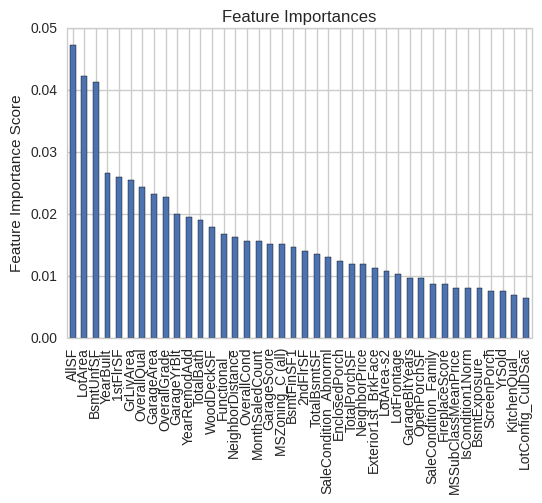

In [13]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `gamma`,Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [14]:
param_test = {'gamma':[0, 0.1, 0.01, 0.001,0.0001, 0.00001]}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'cross-validate best params:', best_param
print 'cross-validate min_mean_rmse:', min_mean_rmse

===========Tuning paramter: gamma ===========
gamma=0 CV RMSE : Mean = 0.1187666 | Std = 0.01080484
gamma=0.100000 CV RMSE : Mean = 0.1202092 | Std = 0.01134678
gamma=0.010000 CV RMSE : Mean = 0.1176393 | Std = 0.01210176
gamma=0.001000 CV RMSE : Mean = 0.1182212 | Std = 0.010909
gamma=0.000100 CV RMSE : Mean = 0.118791 | Std = 0.01083353
gamma=0.000010 CV RMSE : Mean = 0.1187667 | Std = 0.01080479
best  gamma  =  0.01
cross-validate best params: {'gamma': 0.01}
cross-validate min_mean_rmse: 0.117639272727


CV RMSE : Mean = 0.1176393 | Std = 0.01210176
Train RMSE: 0.0703044


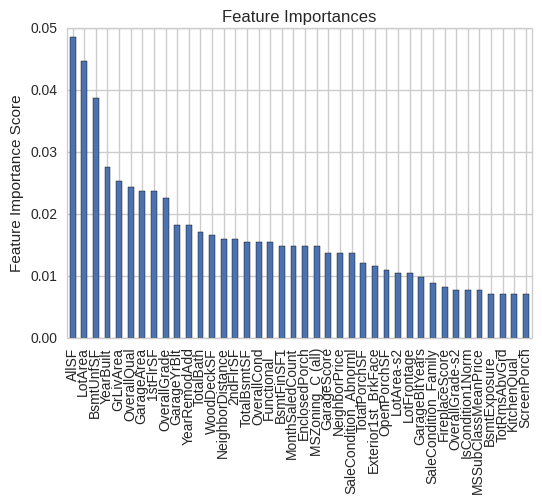

In [15]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `subsample` and `colsample_bytree`

- subsample : Subsample ratio of the training instance.
- colsample_bytree : Subsample ratio of columns when constructing each tree

In [16]:
param_test = {'subsample':common_num_range(0.6, 0.9, 0.01),
               'colsample_bytree':common_num_range(0.6, 0.9, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print 'cross-validate best params:', best_param
print 'cross-validate min_mean_rmse:', min_mean_rmse

===========Tuning paramter: subsample ===========
subsample=0.600000 CV RMSE : Mean = 0.11853 | Std = 0.009544623
subsample=0.610000 CV RMSE : Mean = 0.1194819 | Std = 0.01085016
subsample=0.620000 CV RMSE : Mean = 0.1191252 | Std = 0.008916179
subsample=0.630000 CV RMSE : Mean = 0.1194802 | Std = 0.01018919
subsample=0.640000 CV RMSE : Mean = 0.1195451 | Std = 0.008465812
subsample=0.650000 CV RMSE : Mean = 0.1195613 | Std = 0.009492178
subsample=0.660000 CV RMSE : Mean = 0.118905 | Std = 0.01000774
subsample=0.670000 CV RMSE : Mean = 0.1190643 | Std = 0.008924651
subsample=0.680000 CV RMSE : Mean = 0.1181601 | Std = 0.009822731
subsample=0.690000 CV RMSE : Mean = 0.1174721 | Std = 0.01002793
subsample=0.700000 CV RMSE : Mean = 0.1181038 | Std = 0.008666322
subsample=0.710000 CV RMSE : Mean = 0.1177428 | Std = 0.009409958
subsample=0.720000 CV RMSE : Mean = 0.1167149 | Std = 0.00947304
subsample=0.730000 CV RMSE : Mean = 0.1180531 | Std = 0.009617743
subsample=0.740000 CV RMSE : Mean 

CV RMSE : Mean = 0.116398 | Std = 0.009910425
Train RMSE: 0.0703668


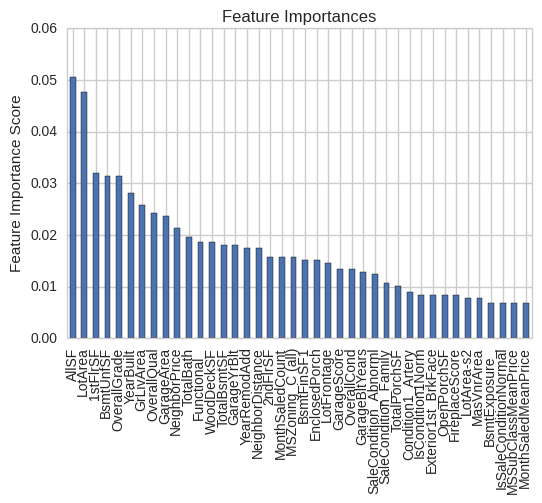

In [17]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

In [18]:
param_test2 = {'reg_lambda':common_num_range(0.55, 0.65, 0.01),
               'reg_alpha':common_num_range(0.45, 0.6, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'cross-validate best params:', best_param
print 'cross-validate min_mean_rmse:', min_mean_rmse

===========Tuning paramter: reg_lambda ===========
reg_lambda=0.550000 CV RMSE : Mean = 0.1187854 | Std = 0.009990398
reg_lambda=0.560000 CV RMSE : Mean = 0.1181966 | Std = 0.009654859
reg_lambda=0.570000 CV RMSE : Mean = 0.1191335 | Std = 0.01051483
reg_lambda=0.580000 CV RMSE : Mean = 0.1189218 | Std = 0.01054659
reg_lambda=0.590000 CV RMSE : Mean = 0.1192189 | Std = 0.01115171
reg_lambda=0.600000 CV RMSE : Mean = 0.1177043 | Std = 0.01008284
reg_lambda=0.610000 CV RMSE : Mean = 0.1175837 | Std = 0.01152538
reg_lambda=0.620000 CV RMSE : Mean = 0.1178612 | Std = 0.01061643
reg_lambda=0.630000 CV RMSE : Mean = 0.1183966 | Std = 0.01022638
reg_lambda=0.640000 CV RMSE : Mean = 0.1182461 | Std = 0.01001321
best  reg_lambda  =  0.61
===========Tuning paramter: reg_alpha ===========
reg_alpha=0.450000 CV RMSE : Mean = 0.1175303 | Std = 0.009891246
reg_alpha=0.460000 CV RMSE : Mean = 0.1173045 | Std = 0.01008641
reg_alpha=0.470000 CV RMSE : Mean = 0.1179391 | Std = 0.01024518
reg_alpha=0.480

CV RMSE : Mean = 0.1167102 | Std = 0.009527794
Train RMSE: 0.0787351


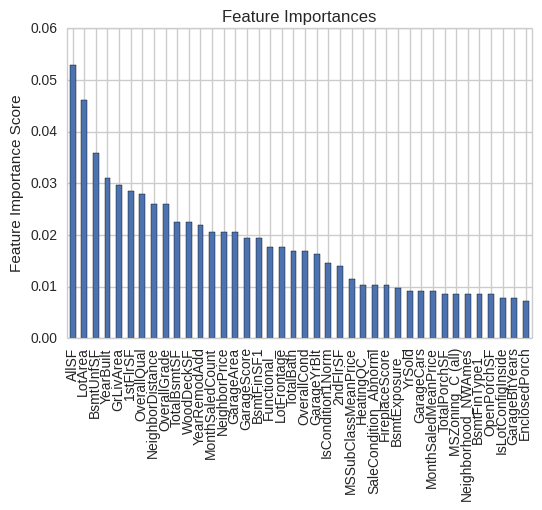

In [19]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)                                           

CV RMSE : Mean = 0.1159143 | Std = 0.01021936
Train RMSE: 0.0599757


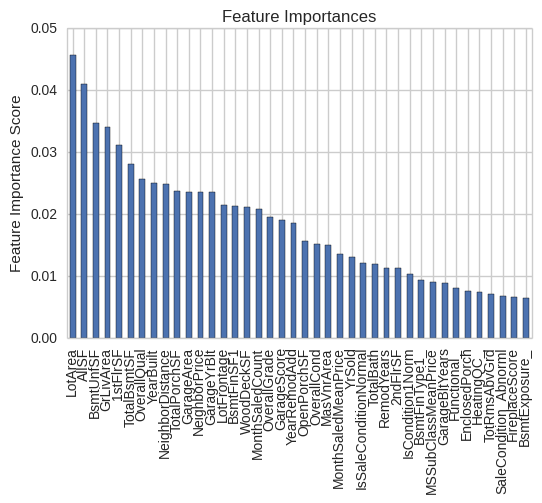

In [33]:
xgb_regressor = XGBRegressor(
                learning_rate =0.01,
                n_estimators = 4000,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)                                           

Final paramters:

```
xgb_regressor = XGBRegressor(
                learning_rate =0.01,
                n_estimators = 4000,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)
```

In [34]:
xgb_predictions = xgb_regressor.predict(test_X)
xgb_predictions = np.expm1(xgb_predictions)

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": xgb_predictions
    })

submission.to_csv("result/xgb_param_tune_predictions_2_13.csv", index=False)

print "Done."

Done.


In [41]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_X, train_Y)
rmse(model_lasso.predict(train_X), train_Y)

0.10126779498053112

In [43]:
lasso_predictions = model_lasso.predict(test_X)
lasso_predictions = np.expm1(lasso_predictions)

In [44]:
predictions = (lasso_predictions + xgb_predictions) / 2

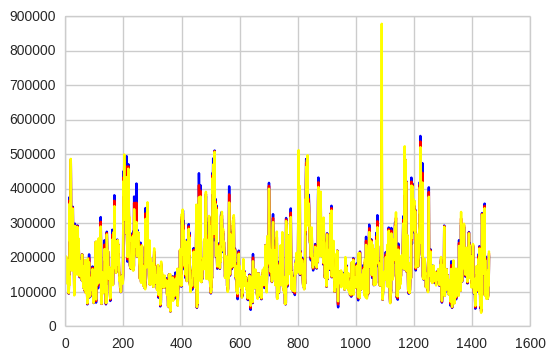

In [45]:
plt.plot(xgb_predictions, c="blue")
plt.plot(predictions, c="red")
plt.plot(lasso_predictions, c="yellow")

In [46]:
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": predictions
    })

submission.to_csv("result/xgb_lasso_param_tune_predictions_2_13.csv", index=False)

print "Done."

Done.


In [47]:
print 'xgb:', rmse(xgb_regressor.predict(train_X), train_Y)
print 'lasso:', rmse(lasso_regressor.predict(train_X), train_Y)
print 'vote:', rmse((lasso_regressor.predict(train_X) + xgb_regressor.predict(train_X))/2, train_Y)

xgb: 0.0599756792052
lasso:

NameError: name 'lasso_regressor' is not defined